* run 1: precision: 0.7, recall: 0.7

In [61]:
%load_ext autoreload
%autoreload 2
import os
import spikeinterface as si
import spikeinterface.core.template_tools as ttools
from spikeinterface import comparison
import pandas as pd
from cebra import CEBRA
import cebra
import torch
import numpy as np
from matplotlib import pyplot as plt
import sklearn
import seaborn as sns
from sklearn import metrics
import cebra.models
import pickle

# set project path
proj_path = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/"
os.chdir(proj_path)

from src.nodes.utils import get_config
from src.nodes import utils

# npx spont. biophy.
cfg_ns, _ = get_config("silico_neuropixels", "concatenated").values()
KS4_ns_10m = cfg_ns["sorting"]["sorters"]["kilosort4"]["10m"][
    "output"
]  # sorting with KS4
GT_ns_10m = cfg_ns["sorting"]["simulation"]["ground_truth"]["10m"]["output"] # KS4 sorting
STUDY_ns = cfg_ns["postprocessing"]["waveform"]["sorted"]["study"]["kilosort4"][
    "10m"
]  # WaveformExtractor
STUDY_ns_su = '/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/0_silico/neuropixels/concatenated_campaigns/postpro/realism/spike/sorted/study_ks4_10m_single_units'

# npx evoked biophy.
cfg_ne, _ = get_config("silico_neuropixels", "stimulus").values()
KS4_ne_10m = cfg_ne["sorting"]["sorters"]["kilosort4"]["10m"]["output"]
GT_ne_10m = cfg_ne["sorting"]["simulation"]["ground_truth"]["10m"]["output"]
STUDY_ne = cfg_ne["postprocessing"]["waveform"]["sorted"]["study"]["kilosort4"][
    "10m"
]  # WaveformExtractor
STUDY_ne_su = '/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/0_silico/4_spikesorting_stimulus_test_neuropixels_8-1-24__8slc_80f_360r_50t_200ms_1_smallest_fiber_gids/0fcb7709-b1e9-4d84-b056-5801f20d55af/postpro/realism/spike/sorted/study_ks4_10m_single_units'



# PATHS

# pre-computed sorted unit quality
quality_path = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/analysis/sorting_quality/sorting_quality.csv"

# model save path
MODEL_PATH_40Khz_s2s_pooled_pm1 = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/analysis/sorting_quality/models/cebra/sf_40Khz/s2s_pooled_pm1"
MODEL_PATH_40Khz_s2s_pooled_pm1_qmetrics = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/analysis/sorting_quality/models/cebra/sf_40Khz/s2s_pooled_pm1_qmetrics"

# axes
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5 # typically between 0.5 and 1
plt.rcParams["axes.linewidth"] = 0.5 #1
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
# legend
legend_cfg = {"frameon": False, "handletextpad": 0.5}
tight_layout_cfg = {"pad": 0.001}
LG_FRAMEON = False              # no legend frame

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024-09-18 09:46:29,316 - root - utils.py - get_config - INFO - Reading experiment config.
2024-09-18 09:46:29,384 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-09-18 09:46:29,388 - root - utils.py - get_config - INFO - Reading experiment config.
2024-09-18 09:46:29,472 - root - utils.py - get_config - INFO - Reading experiment config. - done


In [62]:
# check for GPU
use_cuda = torch.cuda.is_available()
if use_cuda:
    print("__CUDNN VERSION:", torch.backends.cudnn.version())
    print("__Number CUDA Devices:", torch.cuda.device_count())
    print("__CUDA Device Name:", torch.cuda.get_device_name(0))
    print(
        "__CUDA Device Total Memory [GB]:",
        torch.cuda.get_device_properties(0).total_memory / 1e9,
    )

__CUDNN VERSION: 90100
__Number CUDA Devices: 4
__CUDA Device Name: Tesla V100-SXM2-16GB
__CUDA Device Total Memory [GB]: 16.935419904


In [63]:
def get_good_sorted_unit_ids(
    quality, quality_path: str, sorter: str, exp: str, layer: str, fltd_unit: list
):
    """_summary_

    Args:
        quality (_type_): _description_
        quality_path (str): _description_
        sorter (str): _description_
        exp (str): _description_
        layer (str): _description_
        fltd_unit (list): _description_

    Returns:
        np.array(int): filtered sorted unit ids
    """
    # load quality results
    unit_quality = pd.read_csv(quality_path)

    # select a sorted unit and conditions
    df = unit_quality[
        (unit_quality["quality"].str.contains(quality))
        & (unit_quality["experiment"] == exp)
        & (unit_quality["sorter"] == sorter)
        & (unit_quality["layer"] == layer)
    ]
    # filter units based on previous conditions
    df = df[df["sorted"].isin(fltd_unit)]
    return df["sorted"].values.astype(int)


def get_poor_sorted_unit_ids(
    quality, quality_path: str, sorter: str, exp: str, layer: str, fltd_unit: list
):
    """_summary_

    Args:
        quality (_type_): _description_
        quality_path (str): _description_
        sorter (str): _description_
        exp (str): _description_
        layer (str): _description_
        fltd_unit (list[int]): _description_

    Returns:
        np.array[int]: filtered sorted unit ids
    """
    np.array(fltd_unit).astype(int)

    # load quality results
    unit_quality = pd.read_csv(quality_path)

    # select a sorted unit and conditions
    df = unit_quality[
        (unit_quality["quality"] == quality)
        & (unit_quality["experiment"] == exp)
        & (unit_quality["sorter"] == sorter)
        & (unit_quality["layer"] == layer)
    ]
    df = df[df["sorted"].isin(fltd_unit)]
    return df["sorted"].values.astype(int)


def get_spike_dataset_for(
    unit_ids: np.array,
    we,
    max_spikes: int,
    interval_ms: float,
    sfreq: int,
    downsample: int,
):
    """_summary_

    Args:
        unit_ids (np.array[int]): _description_
        we (_type_): _description_
        max_spikes (int): _description_
        interval_ms (float): _description_
        sfreq (int): _description_
        downsample (int): downsample waveforms to produce
        - a lower sampling frequency (e.g., 2 to reduce a 40 KHz frequency
        to 20 KHz)

    Returns:
        _type_: _description_
    """

    # convert interval in ms to samples
    ttp_sp = we.nbefore
    bef_aft_sp = interval_ms * sfreq / 1000
    interval = np.arange(ttp_sp - bef_aft_sp, ttp_sp + bef_aft_sp, 1).astype(int)

    # get all units nearest channels (with extremum amplitude)
    max_chids = ttools.get_template_extremum_channel(we, peak_sign="both")

    # loop over good units
    # 240 samples (-3 to 3 ms at 40KHz)
    wvs = np.zeros((int(max_spikes * we.nbefore * 2 / downsample), 1))
    unit_label = []
    for unit in unit_ids:

        # get its waveforms (num_spikes, num_samples, num_channels)
        wv = we.get_waveforms(unit_id=unit)

        # get its nearest channel
        c_ids = we.sparsity.unit_id_to_channel_ids[unit]
        max_chid = max_chids[unit]
        max_chid_ix = np.where(c_ids == max_chid)[0][0]

        # get waveform for that channels (2D)
        # and (num_samples, num_spikes)
        # TODO: sample instead of taking the first ones
        wv_i = np.array(wv[:max_spikes, interval[::downsample], max_chid_ix]).flatten()[
            :, None
        ]

        # record waveforms
        wvs = np.hstack([wvs, wv_i])

    wvs = wvs[:, 1:]
    # unit_label = np.array(unit_label)
    unit_label = np.array(unit_ids)
    return wvs, unit_label


def get_sorted_unit_best_score(
    KS4_ns_10m: str,
    GT_ns_10m: str,
):
    """Get sorted unit best agreement scores

    Args:
        KS4_ns_10m (str): path of SortingExtractor
        GT_ns_10m (str): path of GroundTruth SortingExtractor

    Returns:
        pd.Series:
        - index_ sorted units
        - values: agreement scores
    """
    SortingTrue = si.load_extractor(GT_ns_10m)
    SortingTrue = SortingTrue.remove_empty_units()
    Sorting = si.load_extractor(KS4_ns_10m)
    comp = comparison.compare_sorter_to_ground_truth(
        SortingTrue,
        Sorting,
        match_mode="hungarian",
        exhaustive_gt=True,
        delta_time=1.3,
        compute_labels=True,
        compute_misclassifications=False,
        well_detected_score=0.8,
        match_score=0.8,  # modified
        redundant_score=0.2,  # default - we don't use that info in this analysis
        overmerged_score=0.2,  # default - we don't use that info in this analysis
        chance_score=0.1,  # default - we don't use that info in this analysis
    )
    return comp.agreement_scores.max()


def get_dataset_for(
    we,
    quality_path: str,
    sorter: str,
    exp: str,
    layer: str,
    max_spikes: int,
    flt_unit: list[int],
    interval_ms: float,
    sfreq: int,
    downsample: int,
):
    """get dataset

    Args:
        we (WaveformExtractor): WaveformExtractor
        quality_path (str): path of the pandas dataframe
        - containing sorted unit quality classification
        sorter (str): one of "KS4", "KS3", "KS2.5", "KS2"...
        - contained in the quality dataframe in the "sorter" column
        exp (str): _description_
        layer (str): _description_
        max_spikes (int): _description_
        flt_unit (list[int]): _description_
        interval_ms (float): _description_
        sfreq (int): _description_
        downsample

    Returns:
        _type_: _description_
    """

    # get good units (filtered based on some conditions)
    g_units = get_good_sorted_unit_ids(
        "good", quality_path, sorter, exp, layer, flt_unit
    )
    wvs_good, good_unit_label = get_spike_dataset_for(
        g_units, we, max_spikes, interval_ms, sfreq, downsample
    )

    # poor units (filtered based on some conditions)
    p_units = get_poor_sorted_unit_ids(
        "mixed: overmerger + oversplitter", quality_path, sorter, exp, layer, flt_unit
    )
    wvs_poor, poor_unit_label = get_spike_dataset_for(
        p_units, we, max_spikes, interval_ms, sfreq, downsample
    )

    # spike dataset
    spike_data = np.hstack([wvs_good, wvs_poor]).T

    # quality label (1D discrete, CEBRA can handle only one)
    quality_label = np.hstack(
        [np.array([1] * len(good_unit_label)), np.array([0] * len(poor_unit_label))]
    )

    # unit ids
    unit_ids = np.hstack([g_units, p_units])

    return spike_data, quality_label, unit_ids


def get_dataset_by_layer(
    sort_path: str,
    gt_path: str,
    study: str,
    quality_path: str,
    sorter: str,
    exp: str,
    num_spike: int,
    interval_ms: float,
    downsample: int,
):
    """get a dataset by layer

    Args:
        sort_path (str): _description_
        gt_path (str): ground truth SortingExtractor
        STUDY (str): _description_
        quality_path (str): _description_
        sorter (str): _description_
        exp (str): _description_
        num_spike (int): _description_
        interval_ms (float): _description_
        downsample (int): can be a factor of 1, 2, 3 ...

    Returns:
        dict: _description_
    """

    # calculate the common maximum number
    # of spikes that it is possible to use
    # across all units (the number of spikes of the
    # least active unit)
    Sorting = si.load_extractor(sort_path)
    unit_spike = Sorting.get_total_num_spikes()
    sfreq = Sorting.get_sampling_frequency()
    print("Recording sampling frequency:", sfreq)

    # select unit ids with at least num_spikes
    n_spike = [unit_spike[key] for key in unit_spike]
    if num_spike == None:
        num_spike = min(n_spike)
        flt_unit = [unit for unit in unit_spike]
    else:
        flt_unit = [unit for unit in unit_spike if unit_spike[unit] > num_spike]

    # get waveformExtractor
    we = si.WaveformExtractor.load_from_folder(study)

    # get data for CEBRA by layer
    # L2/3
    # spike_data_l23, quality_label_l23, unit_ids_l23 = get_dataset_for(
    #     we,
    #     quality_path,
    #     sorter,
    #     exp,
    #     "L2/3",
    #     num_spike,
    #     flt_unit,
    #     interval_ms,
    #     sfreq,
    #     downsample,
    # )
    # L4
    spike_data_l4, quality_label_l4, unit_ids_l4 = get_dataset_for(
        we,
        quality_path,
        sorter,
        exp,
        "L4",
        num_spike,
        flt_unit,
        interval_ms,
        sfreq,
        downsample,
    )
    # L5
    spike_data_l5, quality_label_l5, unit_ids_l5 = get_dataset_for(
        we,
        quality_path,
        sorter,
        exp,
        "L5",
        num_spike,
        flt_unit,
        interval_ms,
        sfreq,
        downsample,
    )
    # L6
    spike_data_l6, quality_label_l6, unit_ids_l6 = get_dataset_for(
        we,
        quality_path,
        sorter,
        exp,
        "L6",
        num_spike,
        flt_unit,
        interval_ms,
        sfreq,
        downsample,
    )

    # get best scores of sorted unit
    best_score = get_sorted_unit_best_score(
        sort_path,
        gt_path,
    )
    print("ex. data shape (L4):", spike_data_l4.shape)
    print("ex. label shape (L4):", quality_label_l4.shape)

    # bundle dataset for model 1 (by layer)
    dataset1 = {
        # "data_l23": spike_data_l23,
        "data_l4": spike_data_l4,
        "data_l5": spike_data_l5,
        "data_l6": spike_data_l6,
        # "label_l23": quality_label_l23,
        "label_l4": quality_label_l4,
        "label_l5": quality_label_l5,
        "label_l6": quality_label_l6,
        # "unit_ids_l23": unit_ids_l23,
        "unit_ids_l4": unit_ids_l4,
        "unit_ids_l5": unit_ids_l5,
        "unit_ids_l6": unit_ids_l6,
        "best_score": best_score,
        "nb_spikes": num_spike,
    }
    return dataset1


def get_dataset_pooled(dat1):

    # spike_data = np.vstack(
    #     [dat1["data_l23"], dat1["data_l4"], dat1["data_l5"], dat1["data_l6"]]
    # )
    # quality_label = np.hstack(
    #     [dat1["label_l23"], dat1["label_l4"], dat1["label_l5"], dat1["label_l6"]]
    # )
    # unit_ids = np.hstack(
    #     [
    #         dat1["unit_ids_l23"],
    #         dat1["unit_ids_l4"],
    #         dat1["unit_ids_l5"],
    #         dat1["unit_ids_l6"],
    #     ]
    # )
    spike_data = np.vstack([dat1["data_l4"], dat1["data_l5"], dat1["data_l6"]])
    quality_label = np.hstack([dat1["label_l4"], dat1["label_l5"], dat1["label_l6"]])
    unit_ids = np.hstack(
        [
            dat1["unit_ids_l4"],
            dat1["unit_ids_l5"],
            dat1["unit_ids_l6"],
        ]
    )
    return {"data": spike_data, "label": quality_label, "unit_ids": unit_ids}


def vanilla_cv_split(label, split, seed):

    np.random.seed(seed)

    # get good unit indices
    good_ix = np.where(label)[0]
    n_tr = int(np.floor(len(good_ix) * split))
    shuffled = np.random.permutation(good_ix)
    g_tr_ix = shuffled[:n_tr]

    # get poor unit indices
    poor_ix = np.where(label == 0)[0]
    n_tr = int(np.floor(len(poor_ix) * split))
    shuffled = np.random.permutation(poor_ix)
    p_tr_ix = shuffled[:n_tr]

    # get train and test indices
    tr_ix = np.hstack([g_tr_ix, p_tr_ix])
    all_ix = np.arange(0, len(label), 1)
    test_ix = np.where(~np.isin(all_ix, tr_ix))[0]
    return tr_ix, test_ix


def get_model1(model_cfg: dict, train: bool, model_path: str, dataset, max_iter):
    """train discrete label-supervised CEBRA"""
    if train:
        # instantiate model
        CebraL23 = CEBRA(**model_cfg)
        CebraL4 = CEBRA(**model_cfg)
        CebraL5 = CEBRA(**model_cfg)
        CebraL6 = CEBRA(**model_cfg)

        # train model
        # CebraL23.fit(dataset["data_l23"], dataset["label_l23"])
        CebraL4.fit(dataset["data_l4"], dataset["label_l4"])
        CebraL5.fit(dataset["data_l5"], dataset["label_l5"])
        CebraL6.fit(dataset["data_l6"], dataset["label_l6"])

        # save model
        utils.create_if_not_exists(model_path)
        # CebraL23.save(model_path + "cebra_l23.pt")
        CebraL4.save(model_path + "cebra_l4.pt")
        CebraL5.save(model_path + "cebra_l5.pt")
        CebraL6.save(model_path + "cebra_l6.pt")
    else:
        # load
        # CebraL23 = cebra.CEBRA.load(model_path + "cebra_l23.pt")
        CebraL4 = cebra.CEBRA.load(model_path + "cebra_l4.pt")
        CebraL5 = cebra.CEBRA.load(model_path + "cebra_l5.pt")
        CebraL6 = cebra.CEBRA.load(model_path + "cebra_l6.pt")

    # get embedding
    # CebraL23_em = CebraL23.transform(dataset["data_l23"])
    CebraL4_em = CebraL4.transform(dataset["data_l4"])
    CebraL5_em = CebraL5.transform(dataset["data_l5"])
    CebraL6_em = CebraL6.transform(dataset["data_l6"])
    return {
        # "model_l23": CebraL23,
        "model_l4": CebraL4,
        "model_l5": CebraL5,
        "model_l6": CebraL6,
        # "l23": CebraL23_em,
        "l4": CebraL4_em,
        "l5": CebraL5_em,
        "l6": CebraL6_em,
    }


def get_model2(model_cfg: dict, train: bool, model_path, dataset, max_iter):
    """train discrete label-supervised CEBRA
    Args
        train (bool)
        model_path (str): save path
        dataset (dict):
        - "data": spike data
        - "label": supervised labels
        max_iter (int): number of training iterations

    Returns:

    """
    if train:
        # instantiate model
        CebraPooled = CEBRA(**model_cfg)
        # train model
        CebraPooled.fit(dataset["data"], dataset["label"])
        # save model
        utils.create_if_not_exists(model_path)
        CebraPooled.save(model_path + "cebra_pooled.pt")
    else:
        # load
        CebraPooled = cebra.CEBRA.load(model_path + "cebra_pooled.pt")

    # get embedding
    CebraPooled_em = CebraPooled.transform(dataset["data"])
    return {"model": CebraPooled, "embedding": CebraPooled_em}


def plot_em(ax, CebraL4_em, quality_label, xlim):
    """plot the embedding, on which dots are
    sorted units colored by sorting quality
    (good in "red", poor in "black")

    Args:
        ax (_type_): axis
        CebraL4_em (np.array): embedding
        quality_label (np.array): quality labels
        - (1: good, 0: poor)

    Returns:
        scat: plot handle
    """
    # set color for good units in red, poor in black
    colr = np.array(["None"] * len(quality_label))
    colr[quality_label == 1] = "r"
    colr[quality_label == 0] = "k"

    # plot
    ax.view_init(20, 45, 0)  # elevation, azimuth, roll
    scat = ax.scatter(
        CebraL4_em[:, 0],
        CebraL4_em[:, 1],
        CebraL4_em[:, 2],
        c=colr,
        edgecolors="w",
        linewidths=0.2,
        s=20,
    )
    # aesthetics
    # disconnect axes (R style)
    ax.spines[["right", "top"]].set_visible(False)
    ax.spines["bottom"].set_position(("axes", -0.05))
    ax.spines["left"].set_position(("axes", -0.05))
    ax.spines["right"].set_visible(False)
    ax.set_xlim(xlim)
    ax.set_ylim(xlim)
    ax.set_zlim(xlim)
    return scat


def plot_model1_em_by_layer(fig, dataset, em, xlim):

    # L2/3
    # ax = fig.add_subplot(1, 4, 1, projection="3d")
    # scat = plot_em(ax, em["l23"], dataset["label_l23"], xlim)
    # ax.set_title("L2/3")
    # L4
    # ax = fig.add_subplot(1, 4, 2, projection="3d")
    ax = fig.add_subplot(1, 3, 1, projection="3d")
    scat = plot_em(ax, em["l4"], dataset["label_l4"], xlim)
    ax.set_title("L4")
    # L5
    # ax = fig.add_subplot(1, 4, 3, projection="3d")
    ax = fig.add_subplot(1, 3, 2, projection="3d")
    scat = plot_em(ax, em["l5"], dataset["label_l5"], xlim)
    ax.set_title("L5")
    # L6
    # ax = fig.add_subplot(1, 4, 4, projection="3d")
    ax = fig.add_subplot(1, 3, 3, projection="3d")
    scat = plot_em(ax, em["l6"], dataset["label_l6"], xlim)
    ax.set_title("L6")
    return fig


def plot_model2_em_by_layer(fig, dataset, em, xlim):
    ax = fig.add_subplot(1, 1, 1, projection="3d")
    scat = plot_em(ax, em, dataset["label"], xlim)
    return ax


def decode(embed_train, embed_test, label_train, label_test):
    """decoding using a k-Nearest Neighbor clustering technique
    We use the fixed number of neighbors 2
    """
    # predict
    decoder = cebra.KNNDecoder(n_neighbors=2, metric="cosine")

    # train kNN on training embedding
    decoder.fit(embed_train, label_train)

    # decode test embedding
    prediction = decoder.predict(embed_test)

    # calculate performance metrics
    # precision and recall are for label 1 ("good" units)
    accuracy = sklearn.metrics.accuracy_score(label_test, prediction)
    bal_accuracy = sklearn.metrics.balanced_accuracy_score(label_test, prediction)
    precision = sklearn.metrics.precision_score(label_test, prediction, pos_label=1)
    recall = sklearn.metrics.recall_score(label_test, prediction, pos_label=1)
    f1_score = sklearn.metrics.f1_score(label_test, prediction, pos_label=1)
    mae = np.median(abs(prediction - label_test))
    r2 = sklearn.metrics.r2_score(label_test, prediction)
    return {
        "metrics": {
            "mae": mae,
            "r2": r2,
            "accuracy": accuracy,
            "bal_accuracy": bal_accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1_score,
        },
        "prediction": prediction,
    }

### Add quality metrics

In [64]:
import shutil
from spikeinterface.postprocessing import compute_principal_components
from spikeinterface.qualitymetrics import compute_quality_metrics as qm

job_kwargs = dict(n_jobs=-1, progress_bar=True)


def get_waveformExtractor_for_single_units(
    sort_path: str,
    study_path,
    save_path: str,
    n_sites=384,
    load_if_exists: bool = False,
    add_pca: bool = True,
    n_components=5,
):
    """Setup WaveformExtractors to calculate quality metrics for single units

    Args:
        sort_path (str): _description_
        study_path (_type_): _description_
        save_path (str): _description_
        n_sites (int, optional): _description_. Defaults to 384.
        load_if_exists: bool=False (bool)
        add_pca (bool): only if load_if_exists=False

    Returns:
        _type_: _description_
    """

    # compute
    if not load_if_exists:
        # get single units
        Sorting = si.load_extractor(sort_path)
        su_ix = np.where(Sorting.get_property("KSLabel") == "good")[0]
        su_unit_ids = Sorting.unit_ids[su_ix]

        # load WaveformExtractor
        We = si.WaveformExtractor.load_from_folder(study_path)

        # create waveformExtractor for single units
        # which we will keep for all downstream analyses
        # this should speed up computations
        shutil.rmtree(save_path, ignore_errors=True)
        WeSu = We.select_units(unit_ids=su_unit_ids, new_folder=save_path)

        # setup two properties required to calculate some quality metrics
        WeSu.recording.set_property("gain_to_uV", np.ones((n_sites,)))
        WeSu.recording.set_property("offset_to_uV", np.zeros((n_sites,)))

        # augment extractors with pca results
        if add_pca:
            _ = compute_principal_components(
                waveform_extractor=WeSu,
                n_components=n_components,
                mode="by_channel_local",
                **job_kwargs,
            )
    else:
        # or load existing
        WeSu = si.WaveformExtractor.load_from_folder(save_path)
    return WeSu


def add_spike_amplitude_extension(we, n_sites, load_if_exists: bool):
    """Add spike amplitudes to WaveformExtractor

    Args:
        we (WaveformExtractor): _description_
        n_sites (int): typically 384 for neuropixels
        load_if_exists (bool): load if exists

    Returns:
        WaveformExtractor: _description_
    """

    # these two properties are required to compute amplitudes
    we.recording.set_property("gain_to_uV", np.ones((n_sites,)))
    we.recording.set_property("offset_to_uV", np.zeros((n_sites,)))

    # compute spike amplitudes
    # or it as an extension
    if not load_if_exists:
        _ = si.postprocessing.compute_spike_amplitudes(we, outputs="by_unit")
    else:
        we.load_extension("spike_amplitudes")

    # unit-test
    assert we.has_extension("spike_amplitudes"), "load spike_amplitudes extension"
    return we


def get_quality_metrics(KS4_ns_10m, STUDY_ns, STUDY_ns_su, n_sites, load_if_exists):

    # (40s)for single units
    # note: adding PCA takes 3 hours (do once, then set load_if_exists=True)
    WeNs = get_waveformExtractor_for_single_units(
        KS4_ns_10m, STUDY_ns, STUDY_ns_su, n_sites=384, load_if_exists=True
    )
    # add spike amplitudes
    WeNs = add_spike_amplitude_extension(WeNs, n_sites=384, load_if_exists=True)

    # pre-compute Spiketinterface quality metrics
    # 20 secs/unit
    qmetrics = qm(
        WeNs,
        qm_params={
            "amplitude_cutoff": {
                "peak_sign": "neg",
                "num_histogram_bins": 100,
                "histogram_smoothing_value": 3,
                "amplitudes_bins_min_ratio": 0,  # instead of 5
            }
        },
        load_if_exists=load_if_exists,
        skip_pc_metrics=True,
        **job_kwargs,
    )
    qmetrics = qmetrics[
        [
            "amplitude_cutoff",
            "firing_range",
            "firing_rate",
            "isi_violations_ratio",
            "presence_ratio",
            "rp_contamination",
            "rp_violations",
            "sd_ratio",
            "snr",
        ]
    ]

    # add silhouette metric (pca-based but fast enough)
    silhouette = qm(
        WeNs,
        metric_names=["silhouette"],
        **job_kwargs,
    )
    qmetrics["silhouette"] = silhouette.values

    # handle missing metrics
    print("****************** Analysing data completion ***************")

    print("Data completion:", qmetrics.notna().sum())

    print("quality metrics are:", qmetrics.columns)

    return qmetrics


def load_results(file_path):
    with open(file_path, "rb") as input_file:
        predictions_all = pickle.load(input_file)
    return predictions_all

### (1m)Load dataset

In [78]:
load_if_exists = False

# calculate quality metrics
qmetrics = get_quality_metrics(KS4_ns_10m, STUDY_ns, STUDY_ns_su, 384, load_if_exists)

# get entired dataset for layer and pooled models
dat1_40Khz = get_dataset_by_layer(
    KS4_ns_10m, GT_ns_10m, STUDY_ns, quality_path, "KS4", "NS", 25, 3, 1
)
dat2_40Khz = get_dataset_pooled(dat1_40Khz)

# add metrics to dataset
dat2_40Khz["data"] = np.hstack(
    [dat2_40Khz["data"], qmetrics.loc[dat2_40Khz["unit_ids"]].values]
)

# unit-test
assert np.isnan(dat2_40Khz["data"]).any() == False, "drop units with nan values"

### Cross-validated decoding

In [68]:
# parameters
torch.manual_seed(0)  # reproducibility
MAX_ITER = 10000  #  10000
TRAIN = True

# model parameters
model_cfg = {
    "model_architecture": "offset10-model",  # 10 receptive field
    "distance": "cosine",  # adapted to contrastive learning
    "batch_size": None,
    "temperature_mode": "auto",
    "learning_rate": 0.001,
    "max_iterations": MAX_ITER,
    "conditional": "time_delta",
    "time_offsets": 10,  # 10 timestep (should be >= nb of receptve fields)
    "output_dimension": 10,
    "device": "cuda_if_available",
    "verbose": True,
}

# Decoding parameters
NFOLD = 20
seed = np.arange(0, NFOLD, 1)
split = 0.8

In [69]:
# cross-validation: loop over KFOLD random
# seeds to get generate different subsets of
# train/test units
NFOLD = 20

seed = np.arange(0, NFOLD, 1)

precision = []
recall = []
test_labels = []
predictions_all = []
models = []
tr_ix_all = []
test_ix_all = []

# loop over sets
for seed_i in seed:

    # get dataset ************************************

    # get train and test
    tr_ix, test_ix = vanilla_cv_split(dat2_40Khz["label"], split=0.8, seed=seed_i)

    # training data
    train_data = dict()
    train_data["data"] = dat2_40Khz["data"][tr_ix, :]
    train_data["label"] = dat2_40Khz["label"][tr_ix]
    train_data["unit_ids"] = dat2_40Khz["unit_ids"][tr_ix]

    # test data
    test_data = dict()
    test_data["data"] = dat2_40Khz["data"][test_ix, :]
    test_data["label"] = dat2_40Khz["label"][test_ix]
    test_data["unit_ids"] = dat2_40Khz["unit_ids"][test_ix]

    # train ***************************

    model2_output = get_model2(
        model_cfg, TRAIN, MODEL_PATH_40Khz_s2s_pooled_pm1_qmetrics, train_data, MAX_ITER
    )

    # decode *******************

    # get embeddings
    train_embed = model2_output["embedding"]
    test_embed = model2_output["model"].transform(test_data["data"])

    # decode
    eval_rez = decode(
        train_embed,
        test_embed,
        train_data["label"],
        test_data["label"],
    )

    # record
    tr_ix_all.append(tr_ix)
    test_ix_all.append(test_ix)
    test_labels.append(test_data["label"])
    predictions_all.append(eval_rez["prediction"])
    precision.append(eval_rez["metrics"]["precision"])
    recall.append(eval_rez["metrics"]["recall"])
    models.append(model2_output)

# save results
with open(
    MODEL_PATH_40Khz_s2s_pooled_pm1_qmetrics + "tr_ix_all.pickle", "wb"
) as handle:
    pickle.dump(tr_ix_all, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(
    MODEL_PATH_40Khz_s2s_pooled_pm1_qmetrics + "test_ix_all.pickle", "wb"
) as handle:
    pickle.dump(test_ix_all, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(
    MODEL_PATH_40Khz_s2s_pooled_pm1_qmetrics + "test_labels.pickle", "wb"
) as handle:
    pickle.dump(test_labels, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(
    MODEL_PATH_40Khz_s2s_pooled_pm1_qmetrics + "predictions_all.pickle", "wb"
) as handle:
    pickle.dump(predictions_all, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(
    MODEL_PATH_40Khz_s2s_pooled_pm1_qmetrics + "precision.pickle", "wb"
) as handle:
    pickle.dump(precision, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(MODEL_PATH_40Khz_s2s_pooled_pm1_qmetrics + "recall.pickle", "wb") as handle:
    pickle.dump(recall, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(MODEL_PATH_40Khz_s2s_pooled_pm1_qmetrics + "models.pickle", "wb") as handle:
    pickle.dump(models, handle, protocol=pickle.HIGHEST_PROTOCOL)

pos: -1.9469 neg:  8.2112 total:  6.2643 temperature:  0.5133:   9%|▊         | 860/10000 [00:28<04:57, 30.71it/s]

In [48]:
LOAD = True

if LOAD:
    test_labels = load_results(
        MODEL_PATH_40Khz_s2s_pooled_pm1_qmetrics + "test_labels.pickle"
    )
    precision = load_results(
        MODEL_PATH_40Khz_s2s_pooled_pm1_qmetrics + "precision.pickle"
    )
    recall = load_results(MODEL_PATH_40Khz_s2s_pooled_pm1_qmetrics + "recall.pickle")
    models = load_results(MODEL_PATH_40Khz_s2s_pooled_pm1_qmetrics + "models.pickle")

### Plot loss

/tmp/ipykernel_34775/1246556617.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(bbox_to_anchor=(1, 1), frameon=False)


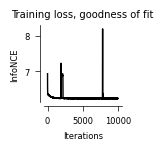

In [54]:
# plot training convergence
fig, ax = plt.subplots(1, 1, figsize=(1, 1))
ax = cebra.plot_loss(models[0]["model"], color=[0, 0, 0], ax=ax)

# legend
ax.legend(bbox_to_anchor=(1, 1), frameon=False)
ax.set_title("Training loss, goodness of fit")
ax.spines[["right", "top"]].set_visible(False)
ax.set_xlabel("Iterations")
ax.set_ylabel("InfoNCE")

# disconnect axes (R style)
ax.spines[["right", "top"]].set_visible(False)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))
ax.spines["right"].set_visible(False)

# save figure
utils.savefig("figures/1_sorting_quality/cebraspike/assets/fig5D_npx_ks4_s2s_loss.svg")

### Plot the last test embedding

NameError: name 'test_embed' is not defined

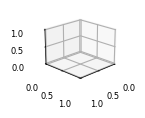

In [42]:
# set color for good units in red, poor in black
colr = np.array(["None"] * len(test_labels[0]))
colr[test_labels[0] == 1] = "r"
colr[test_labels[0] == 0] = "k"

# plot
fig = plt.figure(figsize=(1, 1))
ax = fig.add_subplot(1, 1, 1, projection="3d")
ax.view_init(20, 45, 0)  # elevation, azimuth, rol
scat = ax.scatter(
    test_embed[:, 0],
    test_embed[:, 1],
    test_embed[:, 2],
    c=colr,
    edgecolors="w",
    linewidths=0.2,
    s=20,
)
# aesthetics
# disconnect axes (R style)
ax.spines[["right", "top"]].set_visible(False)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.spines["left"].set_position(("axes", -0.05))
ax.spines["right"].set_visible(False)
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

# # save figure
# utils.savefig(
#     "figures/1_sorting_quality/cebraspike/assets/fig5E_npx_ks4_s2s_test_embed.svg"
# )

0.7141010577792108
0.6911764705882353


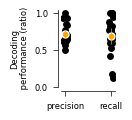

In [53]:
# plot performance
fig, ax = plt.subplots(figsize=(0.7, 1))
df = pd.DataFrame(data=[precision, recall], index=["precision", "recall"]).T
sns.stripplot(ax=ax, data=df, jitter=0.04, color="k", size=5)

# confidence interval


# stats precision
ax.errorbar(
    x=0,
    y=np.mean(precision),
    yerr=1.96 * np.std(precision) / np.sqrt(len(precision)),  # 95% ci
    marker="o",
    color="orange",
    markeredgecolor="w",
    markersize=5,
    zorder=np.inf,
)
# stats recall
ax.errorbar(
    x=1,
    y=np.mean(recall),
    yerr=1.96 * np.std(recall) / np.sqrt(len(recall)),
    marker="o",
    color="orange",
    markeredgecolor="w",
    markersize=5,
    zorder=np.inf,
)

# aesthetics
# disconnect axes (R style)
ax.spines[["right", "top"]].set_visible(False)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))
ax.spines["right"].set_visible(False)
# labels
ax.set_ylim([0, 1.04])
ax.set_ylabel("Decoding\n performance (ratio)")

# report
print(np.mean(precision))
print(np.mean(recall))

# # save figure
utils.savefig("figures/1_sorting_quality/cebraspike/assets/fig5F_npx_ks4_s2s_perf.svg")

### Plot predictions

NameError: name 'predictions_all' is not defined

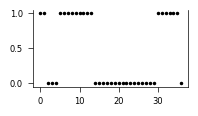

In [60]:
fig, ax = plt.subplots(figsize=(2, 1))
plt.plot(
    test_labels[0],
    linestyle="none",
    marker=".",
    markersize=3,
    color="k",
    label="data",
)
plt.plot(
    predictions_all[0],
    linestyle="none",
    marker="o",
    color="r",
    markersize=4,
    label="prediction",
    markerfacecolor="none",
)

n_units = len(predictions_all)

# aesthetics
# disconnect axes (R style)
ax.spines[["right", "top"]].set_visible(False)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))
ax.spines["right"].set_visible(False)
# labels
ax.set_ylim([0, 1.04])
ax.set_ylabel("Prediction")
ax.set_xlabel("units (id)")
ax.set_xticks(np.arange(0, n_units, 10), np.arange(0, n_units, 10))
ax.set_ylim([-0.1, 1.1])

plt.legend(**legend_cfg, bbox_to_anchor=(0.13, 1), ncol=2)

# save figure
utils.savefig("figures/1_sorting_quality/cebraspike/assets/fig5G_npx_ks4_s2s_preds.svg")